In [4]:
import argparse
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import figure
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

In [5]:
bd1 = 40
bd2 = 160
latency = 200
oracles = {}

In [4]:
oracle_files = open('experiments/test/fct.txt', 'r').readlines()
for i in range(len(oracle_files)-1):
    tokens1 = oracle_files[i].split()
    tokens2 = oracle_files[i+1].split()
    oracles[tokens1[4]]=[int(tokens1[6]),int(tokens2[6])]

In [30]:
def ipToNode(ip):
    return (int(ip, 16)-int('0b000001', 16))/int('00000100', 16)


# i,j are hex ip, size is in bytes
def oracle(i, j, size):
#     if ipToNode(i)/16 == ipToNode(j)/16:
#         return oracles[size][1]
#     return oracles[size][0]
    size = int(size)*8
    if ipToNode(i)/16 == ipToNode(j)/16:
        return size/bd1+latency*2
    return size/bd1+latency*4

In [46]:
def ipToNode(ip):
    return (int(ip, 16)-int('0b000001', 16))/int('00000100', 16)


# i,j are hex ip, size is in bytes
def oracle(i, j, size):
#     size = int(size)*8
    data_transmission_delay = 0
    data_propagation_delay = 0
    header_transmission_delay = 0
    header_propagation_delay = 0
    size = int(size)
    oversubscription_ratio = 1
    hdr_size = 64
    mss = 1000
    if ipToNode(i)/16 == ipToNode(j)/16:
        header_transmission_delay = 2.0 * 8.0 * ((hdr_size) / bd1);
        header_propagation_delay = 2.0 * latency;
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1);
        data_propagation_delay = 2.0 * latency;
    else:
        header_transmission_delay = (2.0 * (8.0 * (hdr_size) / bd1)) + (2.0 * 8.0 * ((hdr_size) / (4 * bd1/oversubscription_ratio)))
        header_propagation_delay = 4.0 * latency
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1) + (2.0 * 8.0*(mss + hdr_size) / (4*bd1/oversubscription_ratio))
        data_propagation_delay = 4.0 * latency

    return data_propagation_delay + data_transmission_delay + header_transmission_delay + header_propagation_delay

In [62]:
oracle('0b000101','0b006401',5000)

3015.2

In [42]:
def slowdown(f,dx):
    slowdowns = []
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            slowdowns.append(
                int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdowns = np.array(slowdowns)
    slowdowns.sort()
    s = 0
    i = 0
    dx = 0.001
    X = np.arange(1, 100, dx)
    Y = []
    for s in X:
        while i < len(slowdowns) and slowdowns[i] < s:
            i += 1
        Y.append(i)
    Y = np.array(Y)
    Y = Y/len(slowdowns)
    return slowdowns,Y

In [43]:
ccs = ['hpcc','timely','dcqcn','dctcp']

In [53]:
def visualize(experiment, dx=0.001):
    slowdowns = []
    cdfs = []
    for cc in ccs:
        result = slowdown("../experiments/{0}/{1}/fct.txt".format(experiment,cc), dx)
        slowdowns.append(result[0])
        cdfs.append(result[1])
    for i in range(len(ccs)):
        mean = np.mean(slowdowns[i])
        median = np.median(slowdowns[i])
        nn = slowdowns[i][int(len(slowdowns[i])*.99)]
        print("{0}: mean: {1}, median: {2}, 99%: {3}".format(ccs[i],mean,median,nn))
        X = np.arange(1, 100, dx)
    for cdf in cdfs:
        pyplot.plot(X, cdf)
    pyplot.xscale('log')
    pyplot.legend(ccs, loc='lower right')
    pyplot.xlabel('log slowdown')
    pyplot.ylabel('cdf')
    pyplot.show()

hpcc: mean: 2.498470201480302, median: 1.3817005545286507, 99%: 18.447028880373992
timely: mean: 14.42829479233092, median: 3.5133779273872676, 99%: 137.06608133086877
dcqcn: mean: 10.884537387114394, median: 3.421763647899474, 99%: 77.52449168207023
dctcp: mean: 2.731457595819219, median: 1.9751594079806503, 99%: 9.764360994418134


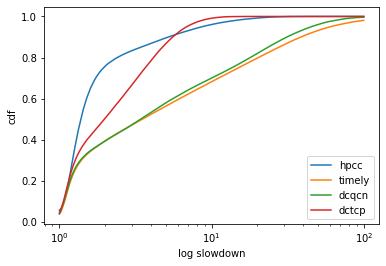

In [54]:
visualize('aditya')

hpcc: mean: 3.57786765723321, median: 2.816, 99%: 16.696795366795367
timely: mean: 18.721534678466114, median: 4.139765342960289, 99%: 157.006
dcqcn: mean: 17.476124975799152, median: 4.071917420814479, 99%: 132.549
dctcp: mean: 4.894104356063847, median: 3.287, 99%: 19.784


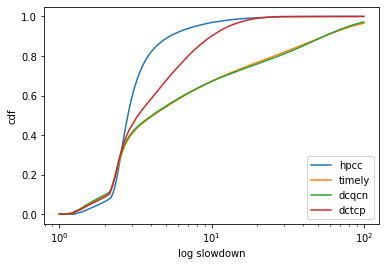

In [27]:
visualize('facebook')

In [56]:
def slowdownBySize(f):
    slowdowns = {}
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            size = int(tokens[4])
            if size not in slowdowns:
                slowdowns[size] = []
            slowdowns[int(tokens[4])].append(int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdownsm = {}
    for size in slowdowns:
        slowdownsm[size] = np.mean(slowdowns[size])
    lists = sorted(slowdownsm.items())
    return lists

In [59]:
def sdvssize(experiment,max_size):
    slowdowns = []
    for cc in ccs:
        result = slowdownBySize("../experiments/{0}/{1}/fct.txt".format(experiment,cc))
        slowdowns.append(result)
    for slowdown in slowdowns:
        x, y = zip(*slowdown)
        pyplot.plot(x,gaussian_filter1d(y, sigma=50))
    pyplot.xscale('log')
    pyplot.yscale('log')
    pyplot.legend(ccs, loc='upper left')
    pyplot.xlabel('flow size')
    pyplot.ylabel('log slowdown')
    pyplot.xticks(np.array([1000,10000,100000,1000000,max_size]), ('1K', '10K', '100K', '1M', str(int(max_size/1000000))+'M'))
    pyplot.show()

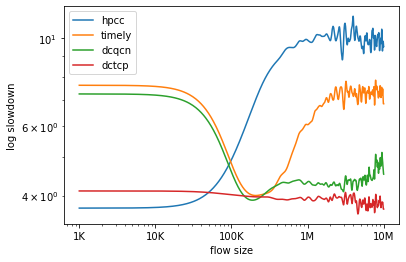

In [100]:
sdvssize('facebook',10000000)

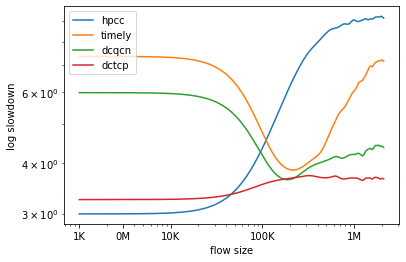

In [60]:
sdvssize('aditya',3000)